# ECFP Transformation Ablation Study

Systematic evaluation of transformations on ECFP representations across multiple datasets.

**Datasets**: ESOL, Lipophilicity, BACE  
**ECFP Types**: Binary, Count  
**Transformations**: Affine, Noise, Normalization, Block Mixing

---

## Setup and Imports

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from IPython.display import display, Markdown

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Import dataset and utilities
from dataset_utils import ECFPDataset
from downstream import run_downstream_task
from transforms import (
    Rotation, Permutation, Scaling, Translation, Shear, Reflection,
    GaussianNoise, L2Normalization, Standardization,
    BlockRadiusLinearMixing
)
from pairwise_distances import (
    analyze_distance_preservation,
    compare_sparsity,
    compute_sparsity_metrics
)
from plots import plot_value_distributions

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print('✓ Setup complete!')

✓ Setup complete!


## Helper Functions

In [25]:
# Store all results globally
all_results = {}

def run_experiment(
    experiment_name,
    dataset_name,
    use_count,
    transform_obj=None,
    n_bits=2048,
    radius=2,
    epochs=100,
    analyze_distances=True,
    sample_size=300
):
    """Run single experiment and store results."""
    task_type = 'classification' if dataset_name == 'bace' else 'regression'
    metric_name = 'ROC-AUC' if task_type == 'classification' else 'RMSE'
    
    print(f'\n[{experiment_name}] {dataset_name.upper()} - {"Count" if use_count else "Binary"} ECFP')
    
    # Load dataset
    dataset = ECFPDataset(
        name=dataset_name,
        split_type='random',
        target_index=0,
        n_bits=n_bits,
        radius=radius,
        use_count=use_count
    )
    
    # Apply transformation if provided
    if transform_obj is not None:
        original_dataset = ECFPDataset(
            name=dataset_name,
            split_type='random',
            target_index=0,
            n_bits=n_bits,
            radius=radius,
            use_count=use_count
        )
        dataset.apply_transform(transform_obj)
    else:
        original_dataset = None
    
    # Downstream task
    result = run_downstream_task(
        dataset,
        task_type=task_type,
        hidden_dim=128,
        epochs=epochs,
        lr=1e-3,
        device='cpu'
    )
    
    print(f'  {metric_name}: Val={result["val"]:.4f}, Test={result["test"]:.4f}')
    
    # Distance preservation
    distances = None
    if analyze_distances and transform_obj is not None:
        distances = analyze_distance_preservation(
            original_dataset,
            dataset,
            metrics=['tanimoto', 'euclidean', 'cosine'],
            correlation_method='spearman',
            sample_size=sample_size
        )
        print(f'  Distance preservation: T={distances["tanimoto"]["correlation"]:.3f}, '
              f'E={distances["euclidean"]["correlation"]:.3f}, '
              f'C={distances["cosine"]["correlation"]:.3f}')
    
    # Store results
    all_results[experiment_name] = {
        'downstream': result,
        'distances': distances
    }
    
    return result

def run_multiradius_experiment(
    experiment_name,
    dataset_name,
    use_count,
    nonlinearity='relu',
    n_bits=6144,
    n_bits_per_radius=2048,
    radius=2,
    epochs=100,
    sample_size=300
):
    """Run multi-radius experiment with block mixing for Binary or Count fingerprints."""
    task_type = 'classification' if dataset_name == 'bace' else 'regression'
    metric_name = 'ROC-AUC' if task_type == 'classification' else 'RMSE'
    ecfp_type = 'Count' if use_count else 'Binary'
    
    print(f'\n[{experiment_name}] {dataset_name.upper()} - Multi-Radius {ecfp_type}')
    
    # Load multi-radius dataset
    original_dataset = ECFPDataset(
        name=dataset_name,
        split_type='random',
        target_index=0,
        radius=radius,
        n_bits=n_bits,
        use_count=use_count,
        multi_radius=True,
        n_bits_per_radius=n_bits_per_radius
    )
    
    # Create transformation if nonlinearity is provided
    if nonlinearity is not None:
        transform = BlockRadiusLinearMixing(
            radius_blocks=original_dataset.radius_schema.blocks,
            nonlinearity=nonlinearity,
            seed=42
        )
        
        dataset = ECFPDataset(
            name=dataset_name,
            split_type='random',
            target_index=0,
            radius=radius,
            n_bits=n_bits,
            use_count=use_count,
            multi_radius=True,
            n_bits_per_radius=n_bits_per_radius
        )
        dataset.apply_transform(transform)
    else:
        dataset = original_dataset
    
    # Downstream task
    result = run_downstream_task(
        dataset,
        task_type=task_type,
        hidden_dim=128,
        epochs=epochs,
        lr=1e-3,
        device='cpu'
    )
    
    print(f'  {metric_name}: Val={result["val"]:.4f}, Test={result["test"]:.4f}')
    
    # Distance preservation (compare transformed to original multi-radius)
    distances = None
    if nonlinearity is not None:
        distances = analyze_distance_preservation(
            original_dataset,
            dataset,
            metrics=['tanimoto', 'euclidean', 'cosine'],
            correlation_method='spearman',
            sample_size=sample_size
        )
        print(f'  Distance preservation: T={distances["tanimoto"]["correlation"]:.3f}, '
              f'E={distances["euclidean"]["correlation"]:.3f}, '
              f'C={distances["cosine"]["correlation"]:.3f}')
    
    # Store results
    all_results[experiment_name] = {
        'downstream': result,
        'distances': distances
    }
    
    return result

print('✓ Helper functions defined!')

✓ Helper functions defined!


## Generate Transformation Objects

In [26]:
# Helper to generate random rotation matrix
def generate_random_rotation(dim, seed=42):
    g = torch.Generator().manual_seed(seed)
    A = torch.randn(dim, dim, generator=g)
    Q, R = torch.linalg.qr(A)
    d = torch.sign(torch.diagonal(R))
    Q = Q * d
    return Q

dim = 2048

# Affine transformations
Q_rotation = generate_random_rotation(dim, seed=42)
rotation_transform = Rotation(Q_rotation)

perm = torch.randperm(dim, generator=torch.Generator().manual_seed(42))
permutation_transform = Permutation(perm)

translation_vec = torch.randn(dim, generator=torch.Generator().manual_seed(44)) * 0.1
translation_transform = Translation(translation_vec)

shear_matrix = torch.eye(dim)
for i in range(min(10, dim-1)):
    shear_matrix[i, i+1] = 0.2
shear_transform = Shear(shear_matrix)

reflection_matrix = -torch.eye(dim)
reflection_transform = Reflection(reflection_matrix)

scales = torch.rand(dim, generator=torch.Generator().manual_seed(42)) * 1.5 + 0.5
scaling_transform = Scaling(scales)

# Noise and normalization
gaussian_noise_transform = GaussianNoise(sigma=0.1, seed=42)
l2_norm_transform = L2Normalization()

print('✓ Transformation objects generated!')

✓ Transformation objects generated!


---
## 1. Baselines

Establish baseline performance for Binary and Count ECFPs on all datasets.

### 1.1 Binary ECFP Baselines

In [27]:
print('='*70)
print('BINARY ECFP BASELINES')
print('='*70)

datasets = ['esol', 'lipo', 'bace']

for dataset in datasets:
    run_experiment(
        experiment_name=f'{dataset}_Binary_Baseline',
        dataset_name=dataset,
        use_count=False,
        transform_obj=None,
        analyze_distances=False
    )

BINARY ECFP BASELINES

[esol_Binary_Baseline] ESOL - Binary ECFP
  RMSE: Val=1.1088, Test=1.0992

[lipo_Binary_Baseline] LIPO - Binary ECFP
  RMSE: Val=0.8108, Test=0.8260

[bace_Binary_Baseline] BACE - Binary ECFP
  ROC-AUC: Val=0.9073, Test=0.8672


### 1.2 Count ECFP Baselines

In [28]:
print('='*70)
print('COUNT ECFP BASELINES')
print('='*70)

for dataset in datasets:
    run_experiment(
        experiment_name=f'{dataset}_Count_Baseline',
        dataset_name=dataset,
        use_count=True,
        transform_obj=None,
        analyze_distances=False
    )

COUNT ECFP BASELINES

[esol_Count_Baseline] ESOL - Count ECFP
  RMSE: Val=0.6703, Test=0.7606

[lipo_Count_Baseline] LIPO - Count ECFP
  RMSE: Val=0.7517, Test=0.7302

[bace_Count_Baseline] BACE - Count ECFP
  ROC-AUC: Val=0.9080, Test=0.8545


---
## 2. Affine Transformations

Test affine transformations: Rotation, Permutation, Translation, Shear, Reflection, Scaling

### 2.1 Rotation

In [29]:
print('='*70)
print('ROTATION')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_Rotation',
        dataset_name=dataset,
        use_count=False,
        transform_obj=rotation_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_Rotation',
        dataset_name=dataset,
        use_count=True,
        transform_obj=rotation_transform
    )

ROTATION

[esol_Binary_Rotation] ESOL - Binary ECFP
  RMSE: Val=1.1268, Test=1.0721
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9998 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9998 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.9994 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=1.000, E=1.000, C=0.999

[esol_Count_Rotation] ESOL - Count ECFP
  RMSE: Val=0.6648, Test=0.6775
Using 300 randomly sampled molecules (

### 2.2 Permutation

In [30]:
print('='*70)
print('PERMUTATION')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_Permutation',
        dataset_name=dataset,
        use_count=False,
        transform_obj=permutation_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_Permutation',
        dataset_name=dataset,
        use_count=True,
        transform_obj=permutation_transform
    )

PERMUTATION

[esol_Binary_Permutation] ESOL - Binary ECFP
  RMSE: Val=1.1024, Test=1.0491
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 1.0000 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 1.0000 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 1.0000 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=1.000, E=1.000, C=1.000

[esol_Count_Permutation] ESOL - Count ECFP
  RMSE: Val=0.7058, Test=0.7745
Using 300 randomly sampled mo

### 2.3 Translation

In [31]:
print('='*70)
print('TRANSLATION')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_Translation',
        dataset_name=dataset,
        use_count=False,
        transform_obj=translation_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_Translation',
        dataset_name=dataset,
        use_count=True,
        transform_obj=translation_transform
    )

TRANSLATION

[esol_Binary_Translation] ESOL - Binary ECFP
  RMSE: Val=1.2379, Test=1.2044
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.2422 (p=0.00e+00)
  -> Poor preservation

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9998 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.2279 (p=0.00e+00)
  -> Poor preservation
  Distance preservation: T=0.242, E=1.000, C=0.228

[esol_Count_Translation] ESOL - Count ECFP
  RMSE: Val=0.7445, Test=0.8161
Using 300 randomly sampled molecules (sam

### 2.4 Shear

In [32]:
print('='*70)
print('SHEAR')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_Shear',
        dataset_name=dataset,
        use_count=False,
        transform_obj=shear_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_Shear',
        dataset_name=dataset,
        use_count=True,
        transform_obj=shear_transform
    )

SHEAR

[esol_Binary_Shear] ESOL - Binary ECFP
  RMSE: Val=1.1184, Test=1.0906
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9996 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9999 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.9996 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=1.000, E=1.000, C=1.000

[esol_Count_Shear] ESOL - Count ECFP
  RMSE: Val=0.6736, Test=0.7434
Using 300 randomly sampled molecules (same samp

### 2.5 Reflection

In [33]:
print('='*70)
print('REFLECTION')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_Reflection',
        dataset_name=dataset,
        use_count=False,
        transform_obj=reflection_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_Reflection',
        dataset_name=dataset,
        use_count=True,
        transform_obj=reflection_transform
    )

REFLECTION

[esol_Binary_Reflection] ESOL - Binary ECFP
  RMSE: Val=1.1467, Test=1.0817
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 1.0000 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 1.0000 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 1.0000 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=1.000, E=1.000, C=1.000

[esol_Count_Reflection] ESOL - Count ECFP
  RMSE: Val=0.6763, Test=0.7782
Using 300 randomly sampled molec

### 2.6 Scaling

In [34]:
print('='*70)
print('SCALING')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_Scaling',
        dataset_name=dataset,
        use_count=False,
        transform_obj=scaling_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_Scaling',
        dataset_name=dataset,
        use_count=True,
        transform_obj=scaling_transform
    )

SCALING

[esol_Binary_Scaling] ESOL - Binary ECFP
  RMSE: Val=1.1158, Test=1.1338
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9463 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9727 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.9427 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=0.946, E=0.973, C=0.943

[esol_Count_Scaling] ESOL - Count ECFP
  RMSE: Val=0.6731, Test=0.7367
Using 300 randomly sampled molecules (sam

---
## 3. Noise Injection

Test Gaussian noise injection to create continuous representations.

### 3.1 Gaussian Noise

In [35]:
print('='*70)
print('GAUSSIAN NOISE (σ=0.1)')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_GaussianNoise',
        dataset_name=dataset,
        use_count=False,
        transform_obj=gaussian_noise_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_GaussianNoise',
        dataset_name=dataset,
        use_count=True,
        transform_obj=gaussian_noise_transform
    )

GAUSSIAN NOISE (σ=0.1)

[esol_Binary_GaussianNoise] ESOL - Binary ECFP
  RMSE: Val=1.5674, Test=1.7148
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.8979 (p=0.00e+00)
  -> Good preservation

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.9899 (p=0.00e+00)
  -> Excellent preservation!

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.8941 (p=0.00e+00)
  -> Good preservation
  Distance preservation: T=0.898, E=0.990, C=0.894

[esol_Count_GaussianNoise] ESOL - Count ECFP
  RMSE: Val=1.0037, Test=0.9437
Using 300 randomly sampled

---
## 4. Normalization

Test L2 Normalization and Standardization.

### 4.1 L2 Normalization

In [36]:
print('='*70)
print('L2 NORMALIZATION')
print('='*70)

for dataset in datasets:
    # Binary ECFP
    run_experiment(
        experiment_name=f'{dataset}_Binary_L2Norm',
        dataset_name=dataset,
        use_count=False,
        transform_obj=l2_norm_transform
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_L2Norm',
        dataset_name=dataset,
        use_count=True,
        transform_obj=l2_norm_transform
    )

L2 NORMALIZATION

[esol_Binary_L2Norm] ESOL - Binary ECFP
  RMSE: Val=1.1190, Test=1.0854
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9924 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.0068 (p=1.52e-01)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 1.0000 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=0.992, E=0.007, C=1.000

[esol_Count_L2Norm] ESOL - Count ECFP
  RMSE: Val=0.9928, Test=0.9614
Using 300 randomly sampled molecules (sa

### 4.2 Standardization

In [37]:
print('='*70)
print('STANDARDIZATION')
print('='*70)

for dataset in datasets:
    # Binary ECFP (create new instance each time since it needs fitting)
    run_experiment(
        experiment_name=f'{dataset}_Binary_Standardization',
        dataset_name=dataset,
        use_count=False,
        transform_obj=Standardization()
    )
    
    # Count ECFP
    run_experiment(
        experiment_name=f'{dataset}_Count_Standardization',
        dataset_name=dataset,
        use_count=True,
        transform_obj=Standardization()
    )

STANDARDIZATION

[esol_Binary_Standardization] ESOL - Binary ECFP
  RMSE: Val=1.3699, Test=1.3319
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.4806 (p=0.00e+00)
  -> Poor preservation

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.7964 (p=0.00e+00)
  -> Good preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.4696 (p=0.00e+00)
  -> Poor preservation
  Distance preservation: T=0.481, E=0.796, C=0.470

[esol_Count_Standardization] ESOL - Count ECFP
  RMSE: Val=1.3212, Test=1.3906
Using 300 randomly sampled molecule

---
## 5. Block Radius Linear Mixing

Test Block Radius Linear Mixing with different activation functions on multi-radius ECFPs.

**Multi-Radius ECFP Approach:**

Multi-radius ECFPs concatenate fingerprints from different radii (r=0, r=1, r=2) where each radius block contains only the unique substructures at that radius (delta approach). This creates a hierarchical representation similar to GNN layers.

**Block Radius Linear Mixing** applies:
1. Orthogonal linear transformation to each radius block independently
2. Nonlinear activation (identity, relu, or tanh)
3. L2 normalization of the concatenated result

This mimics GNN layer-wise processing while respecting ECFP's hierarchical structure.

**Distance Preservation:** For block mixing experiments, we compare the transformed fingerprints to the **original multi-radius fingerprints** (not standard ECFPs) to understand how the transformation affects the hierarchical distance structure.

### 5.1 Multi-Radius Baselines

In [38]:
print('='*70)
print('MULTI-RADIUS BASELINES (No Transformation)')
print('='*70)

for dataset in datasets:
    # Binary multi-radius
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Binary_MultiRadius_Baseline',
        dataset_name=dataset,
        use_count=False,
        nonlinearity=None
    )
    
    # Count multi-radius
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Count_MultiRadius_Baseline',
        dataset_name=dataset,
        use_count=True,
        nonlinearity=None
    )

MULTI-RADIUS BASELINES (No Transformation)

[esol_Binary_MultiRadius_Baseline] ESOL - Multi-Radius Binary
  RMSE: Val=1.1336, Test=1.0848

[esol_Count_MultiRadius_Baseline] ESOL - Multi-Radius Count
  RMSE: Val=0.7018, Test=0.7423

[lipo_Binary_MultiRadius_Baseline] LIPO - Multi-Radius Binary
  RMSE: Val=0.7540, Test=0.7666

[lipo_Count_MultiRadius_Baseline] LIPO - Multi-Radius Count
  RMSE: Val=0.7033, Test=0.6752

[bace_Binary_MultiRadius_Baseline] BACE - Multi-Radius Binary
  ROC-AUC: Val=0.9147, Test=0.8831

[bace_Count_MultiRadius_Baseline] BACE - Multi-Radius Count
  ROC-AUC: Val=0.9090, Test=0.8767


### 5.2 Block Mixing - Identity Activation

In [39]:
print('='*70)
print('BLOCK MIXING - IDENTITY (No Activation)')
print('='*70)

for dataset in datasets:
    # Binary multi-radius with identity activation
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Binary_BlockMixing_Identity',
        dataset_name=dataset,
        use_count=False,
        nonlinearity='identity'
    )
    
    # Count multi-radius with identity activation
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Count_BlockMixing_Identity',
        dataset_name=dataset,
        use_count=True,
        nonlinearity='identity'
    )

BLOCK MIXING - IDENTITY (No Activation)

[esol_Binary_BlockMixing_Identity] ESOL - Multi-Radius Binary
  RMSE: Val=1.0036, Test=1.0465
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9943 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.0450 (p=1.48e-21)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.9992 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=0.994, E=0.045, C=0.999

[esol_Count_BlockMixing_Identity] ESOL - Multi-Radius Count
  RMS

### 5.3 Block Mixing - ReLU Activation

In [40]:
print('='*70)
print('BLOCK MIXING - RELU ACTIVATION')
print('='*70)

for dataset in datasets:
    # Binary multi-radius with ReLU activation
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Binary_BlockMixing_ReLU',
        dataset_name=dataset,
        use_count=False,
        nonlinearity='relu'
    )
    
    # Count multi-radius with ReLU activation
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Count_BlockMixing_ReLU',
        dataset_name=dataset,
        use_count=True,
        nonlinearity='relu'
    )

BLOCK MIXING - RELU ACTIVATION

[esol_Binary_BlockMixing_ReLU] ESOL - Multi-Radius Binary
  RMSE: Val=0.9921, Test=1.0163
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9751 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: -0.0382 (p=5.69e-16)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.9721 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=0.975, E=-0.038, C=0.972

[esol_Count_BlockMixing_ReLU] ESOL - Multi-Radius Count
  RMSE: Val=0.8331, 

### 5.4 Block Mixing - Tanh Activation

In [41]:
print('='*70)
print('BLOCK MIXING - TANH ACTIVATION')
print('='*70)

for dataset in datasets:
    # Binary multi-radius with Tanh activation
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Binary_BlockMixing_Tanh',
        dataset_name=dataset,
        use_count=False,
        nonlinearity='tanh'
    )
    
    # Count multi-radius with Tanh activation
    run_multiradius_experiment(
        experiment_name=f'{dataset}_Count_BlockMixing_Tanh',
        dataset_name=dataset,
        use_count=True,
        nonlinearity='tanh'
    )

BLOCK MIXING - TANH ACTIVATION

[esol_Binary_BlockMixing_Tanh] ESOL - Multi-Radius Binary
  RMSE: Val=1.0018, Test=1.0822
Using 300 randomly sampled molecules (same samples for both datasets)

Analyzing tanimoto distance preservation...
  Computing tanimoto distances on original dataset...
  Computing tanimoto distances on transformed dataset...
  Spearman correlation: 0.9913 (p=0.00e+00)
  -> Excellent preservation!

Analyzing euclidean distance preservation...
  Computing euclidean distances on original dataset...
  Computing euclidean distances on transformed dataset...
  Spearman correlation: 0.0685 (p=7.65e-48)
  -> Poor preservation

Analyzing cosine distance preservation...
  Computing cosine distances on original dataset...
  Computing cosine distances on transformed dataset...
  Spearman correlation: 0.9974 (p=0.00e+00)
  -> Excellent preservation!
  Distance preservation: T=0.991, E=0.069, C=0.997

[esol_Count_BlockMixing_Tanh] ESOL - Multi-Radius Count
  RMSE: Val=0.8244, Te

---
## 6. Results Analysis and Visualization

Comprehensive analysis of all experimental results.

In [42]:
print(f'\nTotal experiments completed: {len(all_results)}')
print('\nExperiment categories:')
print(f"  Baselines: {len([k for k in all_results.keys() if 'Baseline' in k])}")
print(f"  Affine: {len([k for k in all_results.keys() if any(t in k for t in ['Rotation', 'Permutation', 'Translation', 'Shear', 'Reflection', 'Scaling'])])}")
print(f"  Noise: {len([k for k in all_results.keys() if 'Gaussian' in k])}")
print(f"  Normalization: {len([k for k in all_results.keys() if 'L2Norm' in k or 'Standardization' in k])}")
print(f"  Block Mixing: {len([k for k in all_results.keys() if 'BlockMixing' in k or 'MultiRadius' in k])}")


Total experiments completed: 84

Experiment categories:
  Baselines: 12
  Affine: 36
  Noise: 6
  Normalization: 12
  Block Mixing: 24


### 6.1 Performance Comparison by Dataset

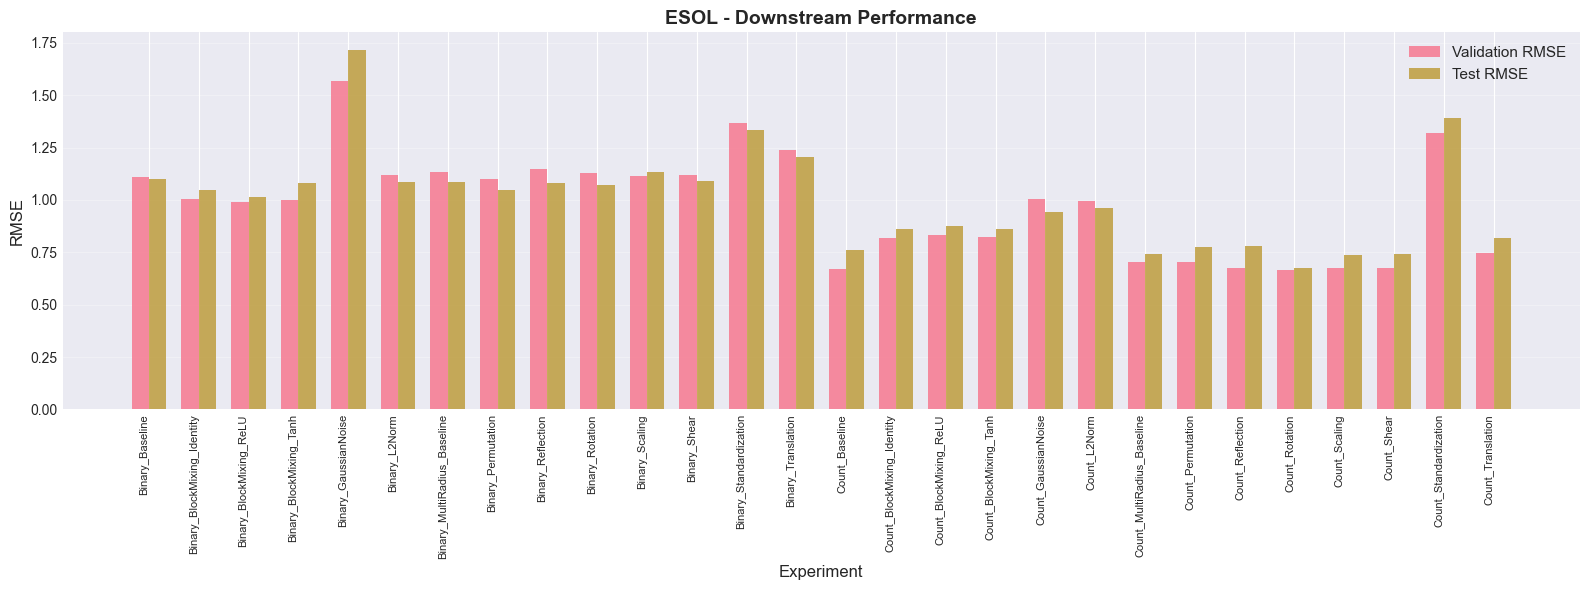


ESOL - Best RMSE:
  Experiment: Count_Rotation
  Val: 0.6648
  Test: 0.6775



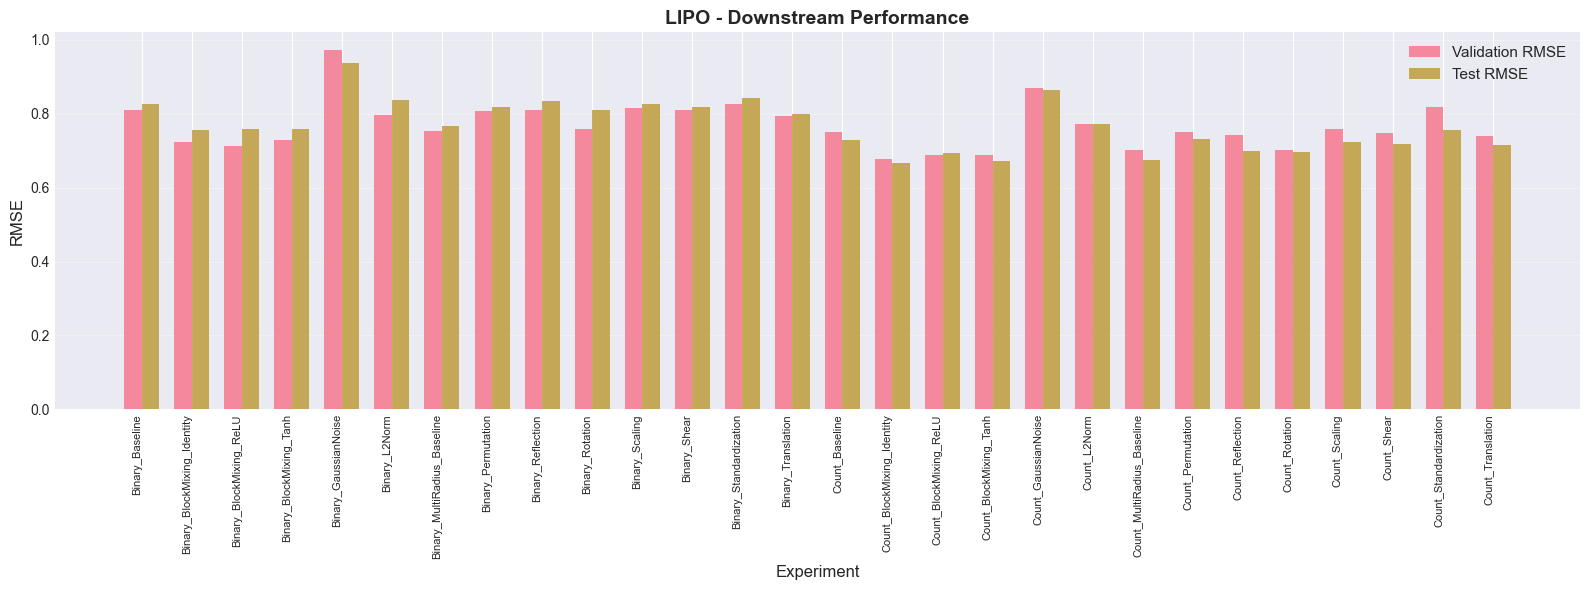


LIPO - Best RMSE:
  Experiment: Count_BlockMixing_Identity
  Val: 0.6784
  Test: 0.6661



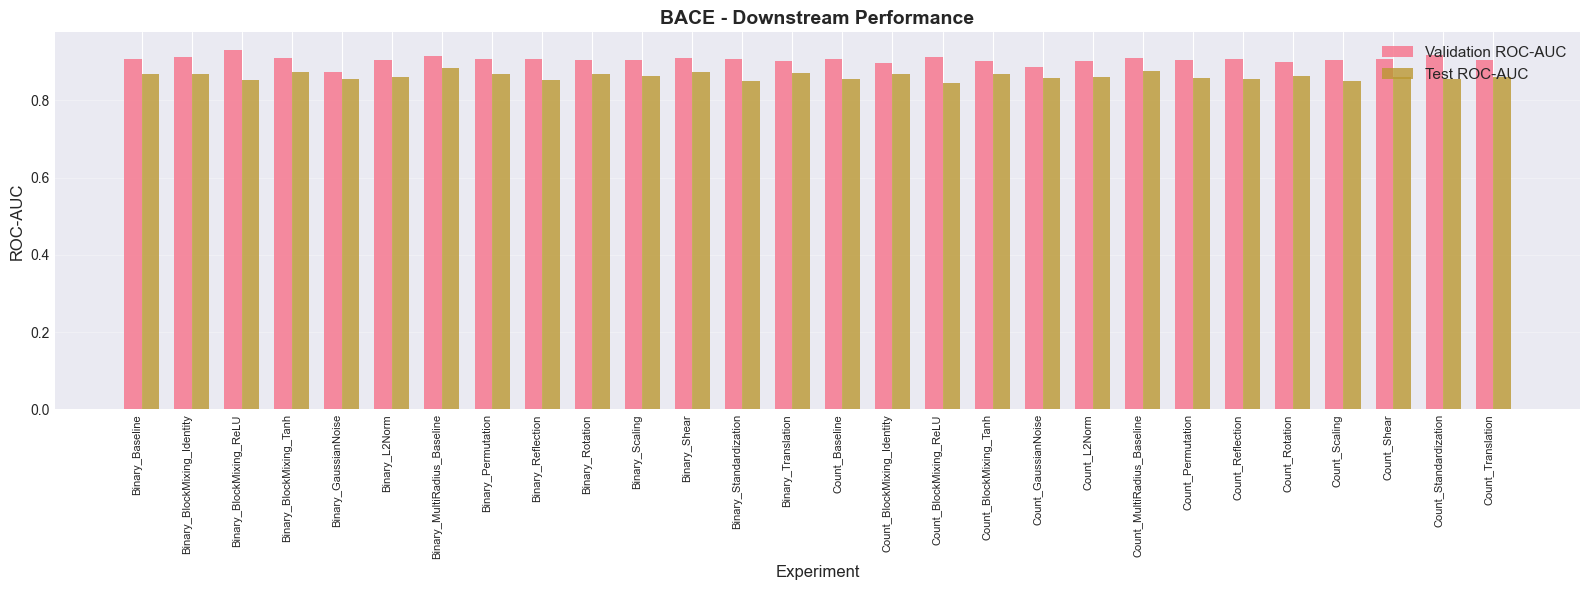


BACE - Best ROC-AUC:
  Experiment: Binary_BlockMixing_ReLU
  Val: 0.9296
  Test: 0.8521



In [43]:
for dataset_name in ['esol', 'lipo', 'bace']:
    task_type = 'classification' if dataset_name == 'bace' else 'regression'
    metric_name = 'ROC-AUC' if task_type == 'classification' else 'RMSE'
    
    # Filter results for this dataset
    dataset_results = {k: v for k, v in all_results.items() if k.startswith(dataset_name)}
    
    # Extract data
    experiments = []
    val_scores = []
    test_scores = []
    
    for key, result in sorted(dataset_results.items()):
        experiments.append(key.replace(f'{dataset_name}_', ''))
        val_scores.append(result['downstream']['val'])
        test_scores.append(result['downstream']['test'])
    
    # Create plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    x = np.arange(len(experiments))
    width = 0.35
    
    ax.bar(x - width/2, val_scores, width, label=f'Validation {metric_name}', alpha=0.8)
    ax.bar(x + width/2, test_scores, width, label=f'Test {metric_name}', alpha=0.8)
    
    ax.set_xlabel('Experiment', fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f'{dataset_name.upper()} - Downstream Performance', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(experiments, rotation=90, ha='right', fontsize=8)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print best result
    best_idx = np.argmin(val_scores) if task_type == 'regression' else np.argmax(val_scores)
    print(f'\n{dataset_name.upper()} - Best {metric_name}:')
    print(f'  Experiment: {experiments[best_idx]}')
    print(f'  Val: {val_scores[best_idx]:.4f}')
    print(f'  Test: {test_scores[best_idx]:.4f}\n')

### 6.2 Distance Preservation Heatmaps

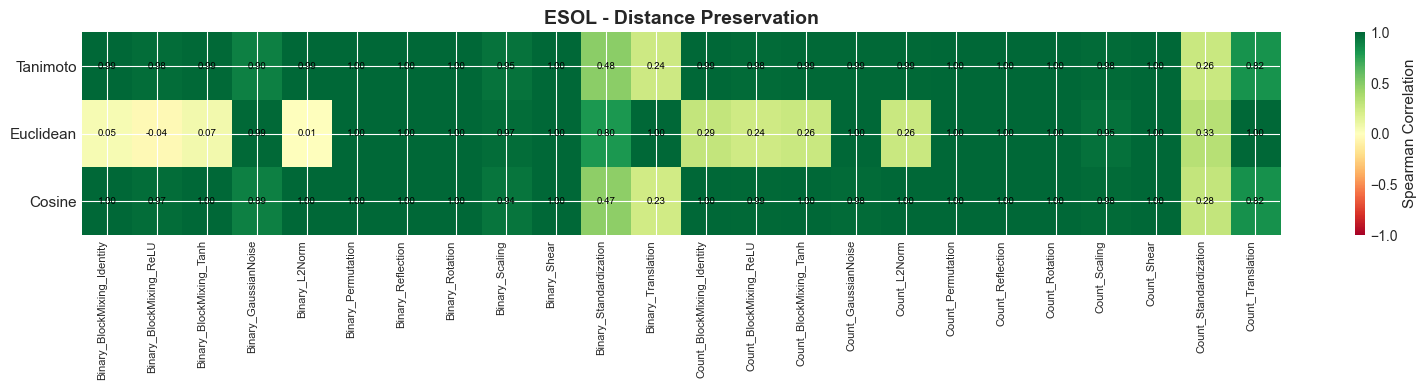


ESOL - Best Distance Preservation:
  Experiment: Binary_Permutation
  Average: 1.0000
  Tanimoto: 1.0000
  Euclidean: 1.0000
  Cosine: 1.0000



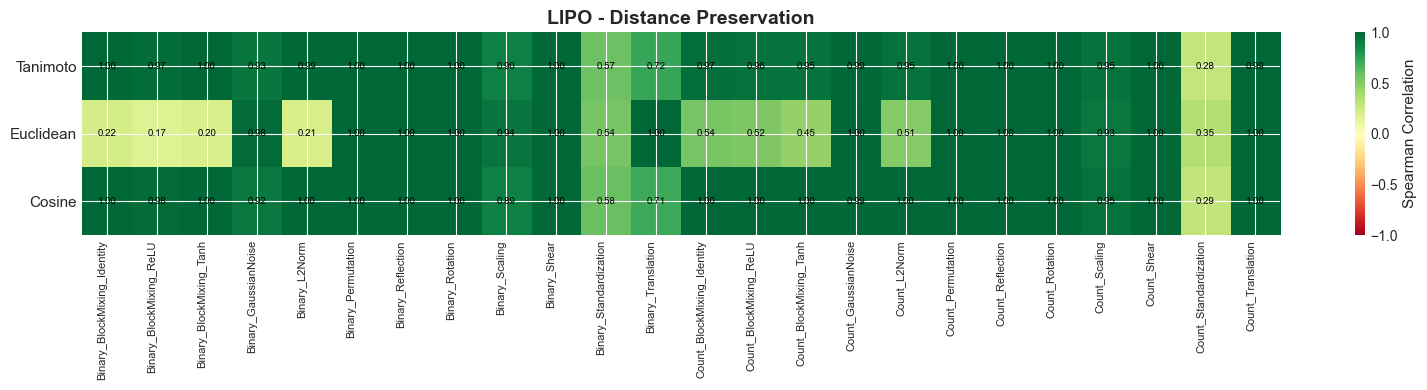


LIPO - Best Distance Preservation:
  Experiment: Binary_Permutation
  Average: 1.0000
  Tanimoto: 1.0000
  Euclidean: 1.0000
  Cosine: 1.0000



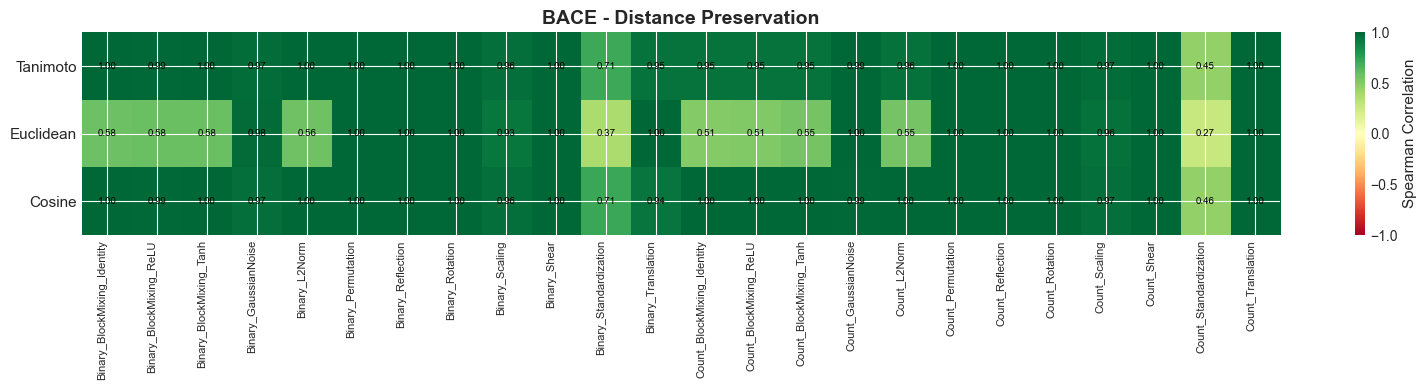


BACE - Best Distance Preservation:
  Experiment: Binary_Permutation
  Average: 1.0000
  Tanimoto: 1.0000
  Euclidean: 1.0000
  Cosine: 1.0000



In [44]:
for dataset_name in ['esol', 'lipo', 'bace']:
    # Filter results with distance metrics
    dataset_results = {k: v for k, v in all_results.items() 
                      if k.startswith(dataset_name) and v['distances'] is not None}
    
    if len(dataset_results) == 0:
        continue
    
    # Extract correlations
    experiments = []
    tanimoto_corr = []
    euclidean_corr = []
    cosine_corr = []
    
    for key, result in sorted(dataset_results.items()):
        experiments.append(key.replace(f'{dataset_name}_', ''))
        tanimoto_corr.append(result['distances']['tanimoto']['correlation'])
        euclidean_corr.append(result['distances']['euclidean']['correlation'])
        cosine_corr.append(result['distances']['cosine']['correlation'])
    
    # Create heatmap
    corr_matrix = np.array([tanimoto_corr, euclidean_corr, cosine_corr])
    
    fig, ax = plt.subplots(figsize=(16, 4))
    
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
    
    ax.set_xticks(np.arange(len(experiments)))
    ax.set_yticks(np.arange(3))
    ax.set_xticklabels(experiments, rotation=90, ha='right', fontsize=8)
    ax.set_yticklabels(['Tanimoto', 'Euclidean', 'Cosine'], fontsize=11)
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman Correlation', fontsize=11)
    
    # Add text annotations
    for i in range(3):
        for j in range(len(experiments)):
            text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                          ha='center', va='center', color='black', fontsize=7)
    
    ax.set_title(f'{dataset_name.upper()} - Distance Preservation', 
                fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print best preservation
    avg_corr = corr_matrix.mean(axis=0)
    best_idx = np.argmax(avg_corr)
    print(f'\n{dataset_name.upper()} - Best Distance Preservation:')
    print(f'  Experiment: {experiments[best_idx]}')
    print(f'  Average: {avg_corr[best_idx]:.4f}')
    print(f'  Tanimoto: {tanimoto_corr[best_idx]:.4f}')
    print(f'  Euclidean: {euclidean_corr[best_idx]:.4f}')
    print(f'  Cosine: {cosine_corr[best_idx]:.4f}\n')

### 6.3 Summary Tables

In [45]:
# Create comprehensive summary table
summary_data = []

for key, result in sorted(all_results.items()):
    row = {
        'Experiment': key,
        'Val Score': result['downstream']['val'],
        'Test Score': result['downstream']['test']
    }
    
    if result['distances'] is not None:
        row['Tanimoto'] = result['distances']['tanimoto']['correlation']
        row['Euclidean'] = result['distances']['euclidean']['correlation']
        row['Cosine'] = result['distances']['cosine']['correlation']
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

display(Markdown('### Complete Results Summary'))
display(summary_df.style.format({
    col: '{:.4f}' for col in summary_df.columns if col != 'Experiment'
}).background_gradient(subset=['Val Score', 'Test Score'], cmap='RdYlGn_r'))

### Complete Results Summary

,Experiment,Val Score,Test Score,Tanimoto,Euclidean,Cosine
0,bace_Binary_Baseline,0.9073,0.8672,nan,nan,nan
1,bace_Binary_BlockMixing_Identity,0.9123,0.8694,0.9984,0.5753,1.0000
2,bace_Binary_BlockMixing_ReLU,0.9296,0.8521,0.9885,0.5846,0.9888
3,bace_Binary_BlockMixing_Tanh,0.9103,0.8724,0.9990,0.5822,1.0000
4,bace_Binary_GaussianNoise,0.8737,0.8549,0.9706,0.9816,0.9685
5,bace_Binary_L2Norm,0.9056,0.8599,0.9985,0.5626,1.0000
6,bace_Binary_MultiRadius_Baseline,0.9147,0.8831,nan,nan,nan
7,bace_Binary_Permutation,0.9064,0.8694,1.0000,1.0000,1.0000
8,bace_Binary_Reflection,0.9060,0.8528,1.0000,1.0000,1.0000
9,bace_Binary_Rotation,0.9055,0.8672,1.0000,0.9998,1.0000


### 6.4 Save Results

In [46]:
# Convert to serializable format
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, torch.Tensor):
        return obj.cpu().numpy().tolist()
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

# Save results
serializable_results = convert_to_serializable(all_results)

with open('ablation_study_results.json', 'w') as f:
    json.dump(serializable_results, f, indent=2)

print('✓ Results saved to ablation_study_results.json')
print(f'\nTotal experiments: {len(all_results)}')

✓ Results saved to ablation_study_results.json

Total experiments: 84
